In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import random
from typing import List, Dict, Any, Tuple, Optional
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.version.cuda)
print(torch.cuda.is_available())

Using device: cuda
12.1
True


In [49]:
csv_path = 'datasets_56102_107707_monthly-beer-production-in-austr.csv'
df = pd.read_csv(csv_path, parse_dates=['Month'], index_col='Month')

In [50]:
# Sliding window and dataset
def make_sliding_windows(series: np.ndarray, dates: np.ndarray, T: int):
    X, Y, Y_dates = [], [], []
    for t in range(T, len(series)):
        X.append(series[t-T:t])
        Y.append(series[t])
        Y_dates.append(dates[t])
    X = np.array(X).reshape(-1, T, 1)
    Y = np.array(Y).reshape(-1)
    Y_dates = np.array(Y_dates)
    return X, Y, Y_dates

class TimeSeriesTorchDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [51]:
# Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return x

In [52]:
# Model
class TransformerForecast(nn.Module):
    def __init__(self, d_model=32, nhead=1, num_layers=1, dim_feedforward=64, dropout=0.1, input_size=1, batch_first=True):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout,
                                                   activation='relu', batch_first=batch_first)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_enc = PositionalEncoding(d_model)
        self.output = nn.Linear(d_model, 1)
        self.batch_first = batch_first

    def forward(self, src):
        x = self.input_proj(src)
        x = self.pos_enc(x)
        x = self.encoder(x)
        last = x[:, -1, :]
        out = self.output(last).squeeze(-1)
        return out

In [53]:
# Training and eval helpers
def train_one_epoch(model, loader, optimizer, criterion, clip=1.0):
    model.train()
    running = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        running += loss.item() * xb.size(0)
        n += xb.size(0)
    return running /n

def evaluate(model, loader, criterion):
    model.eval()
    running = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running += loss.item() * xb.size(0)
            n += xb.size(0)
    return running / n
    
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    return mae, rmse

In [54]:
# Hyperparameter sampling
def sample_hyperparams():
    d_model = random.choice((16, 32, 48, 64, 128, 256))
    possible_nheads = [h for h in (2, 4, 8, 16) if d_model % h == 0]
    if not possible_nheads:
        possible_nheads = [1]
    nhead = random.choice(possible_nheads)
    num_layers = random.choice((1, 2, 3, 4, 5))
    dim_feedforward = d_model * random.choice((2, 4))
    dropout = random.uniform(0.0, 0.3)
    lr = 10**random.uniform(math.log10(1e-4), math.log10(5e-3))
    T = random.choice((6, 12, 24, 36))
    batch_size = random.choice((16, 32, 64, 128))
    return dict(d_model=d_model, nhead=nhead, num_layers=num_layers,
                dim_feedforward=dim_feedforward, dropout=dropout, lr=lr, T=T, batch_size=batch_size)

In [55]:
# Random search hyperparameter tuning
def random_search(df: 'pd.DataFrame',
                  n_trials: int = 12,
                  epochs: int = 60,
                  early_stop: int = 8,
                  verbose: int = 1, # 0 = silent, 1 = detailed, 2 = trials only
                  seed: int = 0) -> Tuple[List[Dict[str, Any]], Optional[Dict[str, Any]]]:
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    colname = df.columns[0]
    series_vals = df[colname].values.astype(float)
    dates = df.index.to_numpy()
    results = []

    train_end = np.datetime64('1983-09-01')
    val_end = np.datetime64('1989-08-01')

    # Record best results to overwrite when a better trial appears
    global_best_val = float('inf')
    best_record = None

    for tnum in range(1, n_trials+1):
        h = sample_hyperparams()
        batch_size = h['batch_size']
        T = h['T']
        X_all, Y_all, Y_dates = make_sliding_windows(series_vals, dates, T)

        train_losses_epoch = []
        val_losses_epoch = []

        # chronological split
        train_idx = np.where(Y_dates <= train_end)[0]
        val_idx = np.where((Y_dates > train_end) & (Y_dates <= val_end))[0]
        test_idx = np.where(Y_dates > val_end)[0]

        X_train, Y_train = X_all[train_idx], Y_all[train_idx]
        X_val, Y_val = X_all[val_idx], Y_all[val_idx]
        X_test, Y_test = X_all[test_idx], Y_all[test_idx]
        dates_test = Y_dates[test_idx]

        # Scaling fit on training data only
        scaler_X = StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_s = scaler_X.transform(X_train.reshape(-1, 1)).reshape(-1, T, 1)
        X_val_s = scaler_X.transform(X_val.reshape(-1, 1)).reshape(-1, T, 1)
        X_test_s = scaler_X.transform(X_test.reshape(-1, 1)).reshape(-1, T, 1)

        scaler_y = StandardScaler().fit(Y_train.reshape(-1, 1))
        Y_train_s = scaler_y.transform(Y_train.reshape(-1, 1)).reshape(-1)
        Y_val_s = scaler_y.transform(Y_val.reshape(-1, 1)).reshape(-1)
        Y_test_s = scaler_y.transform(Y_test.reshape(-1, 1)).reshape(-1)

        train_ds = TimeSeriesTorchDataset(X_train_s, Y_train_s)
        val_ds = TimeSeriesTorchDataset(X_val_s, Y_val_s)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = TransformerForecast(d_model=h['d_model'], nhead=h['nhead'], num_layers=h['num_layers'],
                                    dim_feedforward=h['dim_feedforward'], dropout=h['dropout'],
                                    input_size=1, batch_first=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=h['lr'])
        criterion = nn.MSELoss()

        best_val = float('inf')
        wait = 0
        best_state = None

        if verbose == 1:
            print(f'Trial {tnum}/{n_trials} params: d={h['d_model']} nhead={h['nhead']} layers={h['num_layers']} dimff={h['dim_feedforward']} drop={h['dropout']:.3f} lr={h['lr']:.2e} T={T}')

        for epoch in range(1, epochs+1):
            tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
            val_loss = evaluate(model, val_loader, criterion)

            train_losses_epoch.append(tr_loss)
            val_losses_epoch.append(val_loss)
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                wait = 0
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                wait += 1
            if verbose == 1 and (epoch == 1 or epoch % 10 == 0):
                print(f'epoch {epoch:03d} train={tr_loss:.4f} val={val_loss:.4f} wait={wait}')
            if wait >= early_stop:
                if verbose == 1:
                    print(f'Early stopping at epoch {epoch}')
                break

        if best_state is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        val_preds = []
        model.eval()
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(device)
                out = model(xb).cpu().numpy()
                val_preds.append(out)
        val_preds = np.concatenate(val_preds, axis=0)
        val_preds_unscaled = scaler_y.inverse_transform(val_preds.reshape(-1, 1)).reshape(-1)
        val_true_unscaled = scaler_y.inverse_transform(Y_val_s.reshape(-1, 1)).reshape(-1)
        val_mae, val_rmse = compute_metrics(val_true_unscaled, val_preds_unscaled)

        test_preds = []
        test_ds = TimeSeriesTorchDataset(X_test_s, Y_test_s)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                out = model(xb).cpu().numpy()
                test_preds.append(out)
        if len(test_preds) == 0:
            test_preds = np.array([]).reshape(-1)
        else:
            test_preds = np.concatenate(test_preds, axis=0).reshape(-1)

        test_preds_unscaled = scaler_y.inverse_transform(test_preds.reshape(-1, 1)).reshape(-1)
        test_true_unscaled = scaler_y.inverse_transform(Y_test_s.reshape(-1, 1)).reshape(-1)
        test_mae, test_rmse = compute_metrics(test_true_unscaled, test_preds_unscaled)

        trial_res = {
            'trial': tnum,
            'params': h,
            'val_loss_scaled': float(best_val),
            'val_mae': float(val_mae),
            'val_rmse': float(val_rmse),
            'test_mae': float(test_mae),
            'test_rmse': float(test_rmse)
        }
        results.append(trial_res)

        # Overwrite best_record if this is the new global best with everything needed for plotting
        if best_val < global_best_val - 1e-12:
            global_best_val = float(best_val)
            best_record = {
                'trial': tnum,
                'params':h,
                'val_loss_scaled': float(best_val),
                'scaler_X': scaler_X,
                'scaler_Y': scaler_y,
                'test_dates': pd.to_datetime(dates_test),
                'y_test_true': test_true_unscaled.copy(),
                'y_test_pred': test_preds_unscaled.copy(),
                'model_state_cpu': {k: v.cpu().clone() for k, v in best_state.items()} if best_state is not None else None,
                'loss_history': {
                    'train': train_losses_epoch.copy(),
                    'val': val_losses_epoch.copy()
                },
                'test_mae': float(test_mae),
                'test_rmse': float(test_rmse)
            }

        if verbose == 1:
            print(f' VAL MAE={val_mae:.3f}, VAL RMSE={val_rmse:.3f}\n')
        elif verbose == 2 and (tnum % 10 == 0 or tnum == n_trials):
            print(f'Trial {tnum}/{n_trials}')
        
    results = sorted(results, key=lambda x: x['val_loss_scaled'])
    return results, best_record

In [56]:
results, best = random_search(df, n_trials=200, epochs=40, early_stop=8, verbose=2)

print('Top 3 by validation loss:')
for r in results[:3]:
    print(f'trial {r['trial']:3d} | val_rmse={r['val_rmse']:3f} | val_loss={r['val_loss_scaled']:.6f} | params={r['params']}')

top_by_test = sorted(results, key=lambda x: x.get('test_rmse', float('inf')))[:3]
print('\nTop 3 by test RMSE:')
for r in top_by_test:
    print(f'trial {r['trial']:3d} | test_rmse={r['test_rmse']:3f} | val_loss={r['val_loss_scaled']:.6f} | params={r['params']}')

val_rec = results[0]
print('Best model (selected by lowest validation loss)')
print(f'trial={val_rec['trial']} | val_loss={val_rec['val_loss_scaled']:.6f} | '
      f'val_mae={(val_rec['val_mae']):.3f} | val_rmse={val_rec['val_rmse']:.3f} | '
      f'test_mae={val_rec['test_mae']:.3f} | test_rmse={val_rec['test_rmse']:.3f}')
print(f'Params: {val_rec['params']}')

Trial 10/200
Trial 20/200
Trial 30/200
Trial 40/200
Trial 50/200
Trial 60/200
Trial 70/200
Trial 80/200
Trial 90/200
Trial 100/200
Trial 110/200
Trial 120/200
Trial 130/200
Trial 140/200
Trial 150/200
Trial 160/200
Trial 170/200
Trial 180/200
Trial 190/200
Trial 200/200
Top 3 by validation loss:
trial  46 | val_rmse=11.987454 | val_loss=0.125458 | params={'d_model': 64, 'nhead': 16, 'num_layers': 2, 'dim_feedforward': 128, 'dropout': 0.0029113978301442468, 'lr': 0.0015804566584916209, 'T': 24, 'batch_size': 64}
trial  75 | val_rmse=12.246213 | val_loss=0.127029 | params={'d_model': 32, 'nhead': 16, 'num_layers': 4, 'dim_feedforward': 64, 'dropout': 0.07438730066910153, 'lr': 0.0005893766217803297, 'T': 12, 'batch_size': 64}
trial 189 | val_rmse=12.351125 | val_loss=0.129215 | params={'d_model': 32, 'nhead': 4, 'num_layers': 5, 'dim_feedforward': 64, 'dropout': 0.23415599731289155, 'lr': 0.0007295638944538582, 'T': 12, 'batch_size': 16}

Top 3 by test RMSE:
trial 131 | test_rmse=10.2300

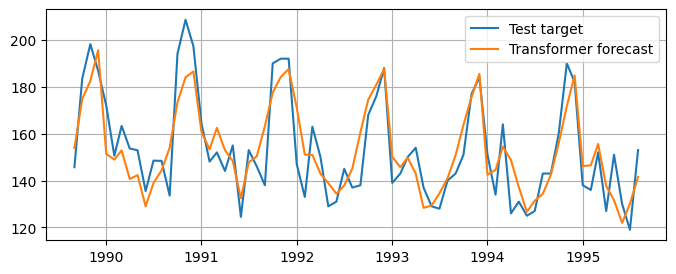

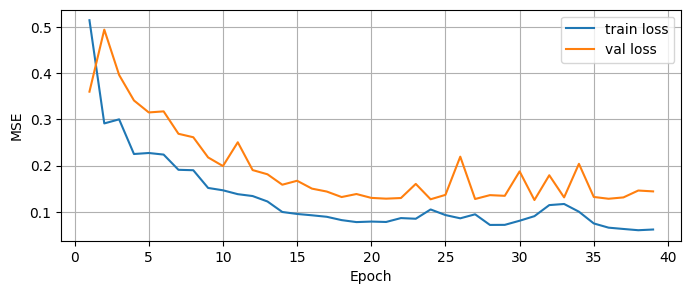

In [57]:
if best is not None:
    # Forecast plot 
    plt.figure(figsize=(8, 3))
    plt.plot(best['test_dates'], best['y_test_true'], label='Test target')
    plt.plot(best['test_dates'], best['y_test_pred'], label='Transformer forecast')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss plot
    lh = best['loss_history']
    plt.figure(figsize=(8,3))
    plt.plot(np.arange(1, len(lh['train'])+1), lh['train'], label='train loss')
    plt.plot(np.arange(1, len(lh['val'])+1), lh['val'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

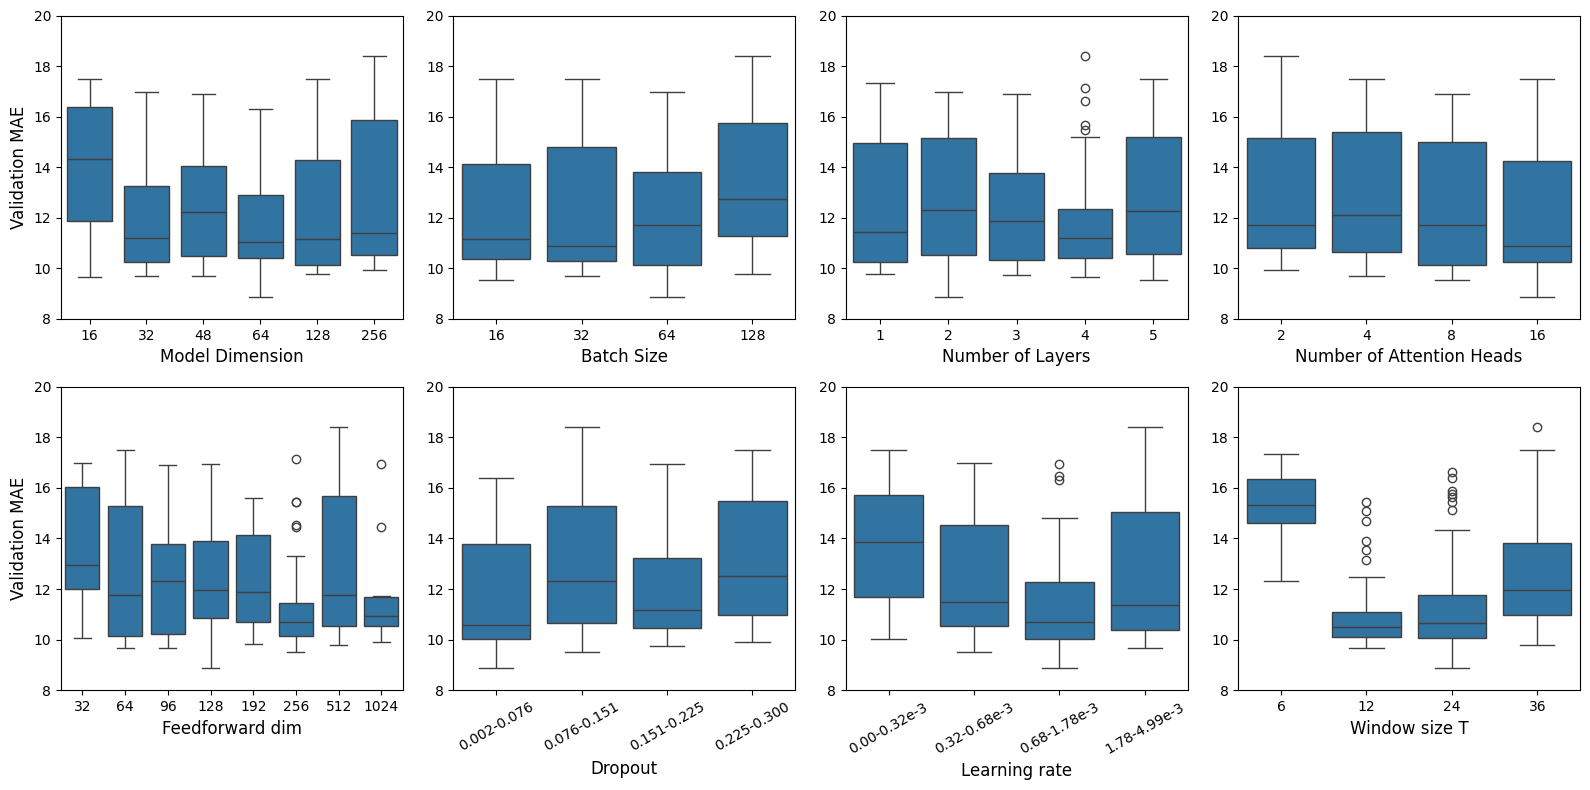

In [58]:
df_res = pd.DataFrame(results)
hyperparams_df = df_res['params'].apply(pd.Series)

int_cols = ['d_model', 'batch_size', 'num_layers', 'nhead', 'T', 'dim_feedforward']
for col in int_cols:
    if col in hyperparams_df.columns:
        hyperparams_df[col] = hyperparams_df[col].astype(int)

if 'dropout' in hyperparams_df.columns:
    hyperparams_df['dropout_bin'] = pd.cut(hyperparams_df['dropout'], bins=4)
    formatted = []
    for interval in hyperparams_df['dropout_bin'].cat.categories:
        formatted.append(f'{interval.left:.3f}-{interval.right:.3f}')
    hyperparams_df['dropout_bin'] = hyperparams_df['dropout_bin'].cat.rename_categories(formatted)

# Smallest lr can show up as negative for some reason, clip it
if 'lr' in hyperparams_df.columns:
    lr_values = hyperparams_df['lr'].astype(float).clip(lower=0)
    hyperparams_df['lr_bin'] = pd.qcut(lr_values, q=4, duplicates='drop')
    cleaned_intervals = []
    for interval in hyperparams_df['lr_bin'].cat.categories:
        left = max(interval.left, 0)
        right = max(interval.right, 0)
        cleaned_intervals.append(pd.Interval(left, right))

    edges = [i.left for i in cleaned_intervals] + [i.right for i in cleaned_intervals]
    exponent = int(np.floor(np.log10(max(edges))))

    formatted = []
    for interval in cleaned_intervals:
        left = interval.left / (10**exponent)
        right = interval.right / (10**exponent)
        formatted.append(f'{left:.2f}-{right:.2f}e{exponent:+d}')
    hyperparams_df['lr_bin'] = hyperparams_df['lr_bin'].cat.rename_categories(formatted)

evaluation_df = pd.concat([hyperparams_df, df_res['val_mae']], axis=1)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
y_limits = (8, 20)
label_fontsize = 12

# Box plots for different hyperparameters
sns.boxplot(x='d_model', y='val_mae', data=evaluation_df, ax=axes[0, 0])
axes[0, 0].set_xlabel('Model Dimension', fontsize=label_fontsize)
axes[0, 0].set_ylabel('Validation MAE', fontsize=label_fontsize)
axes[0, 0].set_ylim(y_limits)

sns.boxplot(x='batch_size', y='val_mae', data=evaluation_df, ax=axes[0, 1])
axes[0, 1].set_xlabel('Batch Size', fontsize=label_fontsize)
axes[0, 1].set_ylabel('')
axes[0, 1].set_ylim(y_limits)

sns.boxplot(x='num_layers', y='val_mae', data=evaluation_df, ax=axes[0, 2])
axes[0, 2].set_xlabel('Number of Layers', fontsize=label_fontsize)
axes[0, 2].set_ylabel('')
axes[0, 2].set_ylim(y_limits)

sns.boxplot(x='nhead', y='val_mae', data=evaluation_df, ax=axes[0, 3])
axes[0, 3].set_xlabel('Number of Attention Heads', fontsize=label_fontsize)
axes[0, 3].set_ylabel('')
axes[0, 3].set_ylim(y_limits)

sns.boxplot(x='dim_feedforward', y='val_mae', data=evaluation_df, ax=axes[1, 0])
axes[1, 0].set_xlabel('Feedforward dim', fontsize=label_fontsize)
axes[1, 0].set_ylabel('Validation MAE', fontsize=label_fontsize)
axes[1, 0].set_ylim(y_limits)

sns.boxplot(x='dropout_bin', y='val_mae', data=evaluation_df, ax=axes[1, 1])
axes[1, 1].set_xlabel('Dropout', fontsize=label_fontsize)
axes[1, 1].set_ylabel('')
axes[1, 1].set_ylim(y_limits)
for lbl in axes[1,1].get_xticklabels():
    lbl.set_rotation(30)

sns.boxplot(x='lr_bin', y='val_mae', data=evaluation_df, ax=axes[1, 2])
axes[1, 2].set_xlabel('Learning rate', fontsize=label_fontsize)
axes[1, 2].set_ylabel('')
axes[1, 2].set_ylim(y_limits)
for lbl in axes[1,2].get_xticklabels():
    lbl.set_rotation(30)

sns.boxplot(x='T', y='val_mae', data=evaluation_df, ax=axes[1, 3])
axes[1, 3].set_xlabel('Window size T', fontsize=label_fontsize)
axes[1, 3].set_ylabel('')
axes[1, 3].set_ylim(y_limits)

plt.tight_layout()
plt.show()